In [1]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.decomposition import PCA 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression       # linear regression model
from sklearn.ensemble import RandomForestRegressor      # model-based feature importance
from sklearn.feature_selection import mutual_info_regression # mutual information
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score,mean_absolute_error
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import random

In [2]:
def plot_corr(dataframe,size=10):                       # plots a correlation matrix as a heat map 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    plt.show()

In [3]:
def random_forest_feature_selection(X,Y):
    seed = 73093                                                # set the random forest hyperparameters
    max_depth = 7
    min_samples_leaf = 5
    num_tree = 1000
    max_features = 10
    random_forest = RandomForestRegressor(min_samples_leaf = min_samples_leaf,random_state=seed,n_estimators=num_tree, max_features=max_features)
    random_forest.fit(X,Y) # fit the random forest
    y_hat = random_forest.predict(X)
    importance_rank = random_forest.feature_importances_ # extract the expected feature importances
    importance_rank_stand = importance_rank/np.max(importance_rank)                          # calculate relative mutual information

    std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],axis=0) # calculate stdev over trees
    indices = np.argsort(importance_rank)[::-1]             # find indicies for descending order
    print(indices)
    print(X.columns[indices])

    plt.plot()                                        # plot the feature importance 
    plt.title("Random Forest-based Feature importances")
    plt.bar(range(X.shape[1]), importance_rank[indices],edgecolor = 'black',
           color="darkorange",alpha = 0.6, yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices],rotation=90)
    plt.xlim([-0.5, X.shape[1]-0.5]); 
    plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    #plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
    plt.ylim([0.,1.0])
    plt.xlabel('Predictor Feature'); plt.ylabel('Feature Importance')
    plt.show()
    
    return indices, X.columns[indices]

In [4]:
def random_forest_grid_search(X,Y,max_depth,min_samples_leaf,num_tree,max_features):
    
    seed = 73093                                                # set the random forest hyperparameters
    random_forest = RandomForestRegressor(min_samples_leaf = min_samples_leaf,random_state=seed,n_estimators=num_tree, max_features=max_features)
    
    #####split the data#####
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=104,test_size=0.20, shuffle=True)
    
    random_forest.fit(X_train,Y_train) # fit the random forest
    
    Y_pred = random_forest.predict(X_test)
    Y_train_pred = random_forest.predict(X_train)
   
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))
    print("MAE: %.2f" % mean_absolute_error(Y_test, Y_pred))
    
    return r2_score(Y_test, Y_pred)


In [5]:
def mutual_info_feature_selection(X,Y):
    mi = mutual_info_regression(X,Y)              # calculate mutual information
    mi /= np.max(mi)                                        # calculate relative mutual information

    indices = np.argsort(mi)[::-1]                          # find indicies for descending order

    print("Feature ranking:")                               # write out the feature importances
    for f in range(X.shape[1]):
        print("%d. feature %s = %f" % (f + 1, X.columns[indices][f], mi[indices[f]]))

    plt.plot()                                        # plot the relative mutual information 
    plt.title("Mutual Information")
    plt.bar(range(X.shape[1]), mi[indices],edgecolor = 'black',
           color="darkorange",alpha=0.6,align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices],rotation=90)
    plt.xlim([-0.5, X.shape[1]-0.5]); plt.ylim([0,1.3])
    plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    #plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
    plt.xlabel('Predictor Feature'); plt.ylabel('Mutual Information')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.5)
    plt.show()
    
    return indices, X.columns[indices]

In [6]:
def delta_mutual_information_quotient(x,y):             # standard mutual information quotient
    delta_mutual_information_quotient = []               
    
    Ixy = []
    for m, mcol in enumerate(x.columns):
        Ixy.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
    Vs = np.average(Ixy)
    Ixx = []
    for m, mcol in enumerate(x.columns):
        for n, ncol in enumerate(x.columns):
            Ixx.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))
    Ws = np.average(Ixx) 
    
    for i, icol in enumerate(x.columns):          
        Ixy_s = []                                          
        for m, mcol in enumerate(x.columns):
            if m != i:
                Ixy_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
        Vs_s = np.average(Ixy_s)
        Ixx_s = []
        for m, mcol in enumerate(x.columns):
            if m != i:
                for n, ncol in enumerate(x.columns):
                    if n != i:
                        Ixx_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))                  
        Ws_s = np.average(Ixx_s)
        delta_mutual_information_quotient.append((Vs/Ws)-(Vs_s/Ws_s))
    
    delta_mutual_information_quotient  = np.asarray(delta_mutual_information_quotient).reshape(-1)  
    return delta_mutual_information_quotient

In [7]:
####pre-processing
df = pd.read_csv("HackathonData2024.csv")

target_name = "Avg Pump Difference"
df_pred = df[df[target_name].isnull()]
df.dropna(subset=[target_name],inplace=True)

fluid_name = "Fluid System"
df.dropna(subset=[fluid_name],inplace=True)

In [8]:
df_pred

,Well ID,Avg Pump Difference,Area,Lateral Length,Fluid System,TVD,Development Strategy,DELAYED,BOUND_CODE,CODEV_POSITION,...,CODEV_3000_AVG_TVD_DIST,CODEV_3000_AVG_WELL_AGE,CODEV_3000_MEDIAN_WELL_AGE,CODEV_3000_WELL_COUNT,Pressure Gradient (psi/ft) new,Soak Time,Avg Open Pressure,SD Open Pressure,Avg Close Pressure,SD Close Pressure
3,4,NaN,Arches,11000,Campbell,10555.0,Coke,1,11110000,Edge,...,4,0.0,0.0,1,0.501287,30,2653.539415,206.7,1304.162878,551.5
29,31,NaN,Everglades,10900,Williams,8160.0,Coke,1,10001000,Edge,...,44,5.0,5.0,4,0.489195,105,2641.403093,182.2,2330.649788,712.4
40,42,NaN,Grand Canyon,7600,Campbell,9475.0,Orange Crush,0,111000,Edge,...,689,-1.4,-1.5,10,0.577162,124,3188.784956,153.3,2573.689381,522.2
50,52,NaN,Great Sand Dunes,7500,Campbell,8480.0,Orange Crush,1,11110111,Middle,...,393,1.2,1.0,5,0.562310,220,3082.436237,188.3,2862.491012,402.2
69,71,NaN,Great Basin,9800,Young,10545.0,Coke,1,11111000,Edge,...,17,0.0,0.0,1,0.500517,62,NaN,NaN,1554.261093,218.6
74,76,NaN,Kings Canyon,9900,Campbell,8985.0,Orange Crush,1,11111101,Edge,...,626,0.7,1.0,3,0.562929,435,3397.596960,261.9,2263.980877,370.3
89,96,NaN,Carlsbad Caverns,10100,Williams,8335.0,Mountain Dew,0,10001001,Middle,...,21,7.1,16.0,7,0.514748,47,2756.766649,188.4,2073.483878,380.3
124,131,NaN,Big Bend,10200,Williams,8860.0,Mountain Dew,1,11111010,Middle,...,195,0.0,0.0,5,0.588177,491,3120.067826,214.9,2437.221124,529.3
130,137,NaN,Dry Tortugas,7300,Campbell,8920.0,Orange Crush,1,11011000,Edge,...,400,2.0,2.0,2,0.606818,38,3148.416568,146.8,3195.083894,1018.0
187,194,NaN,Great Basin,10000,Young,8915.0,Orange Crush,1,11111100,Edge,...,664,12.0,12.0,4,0.523895,100,2471.255945,105.0,2472.226587,313.8


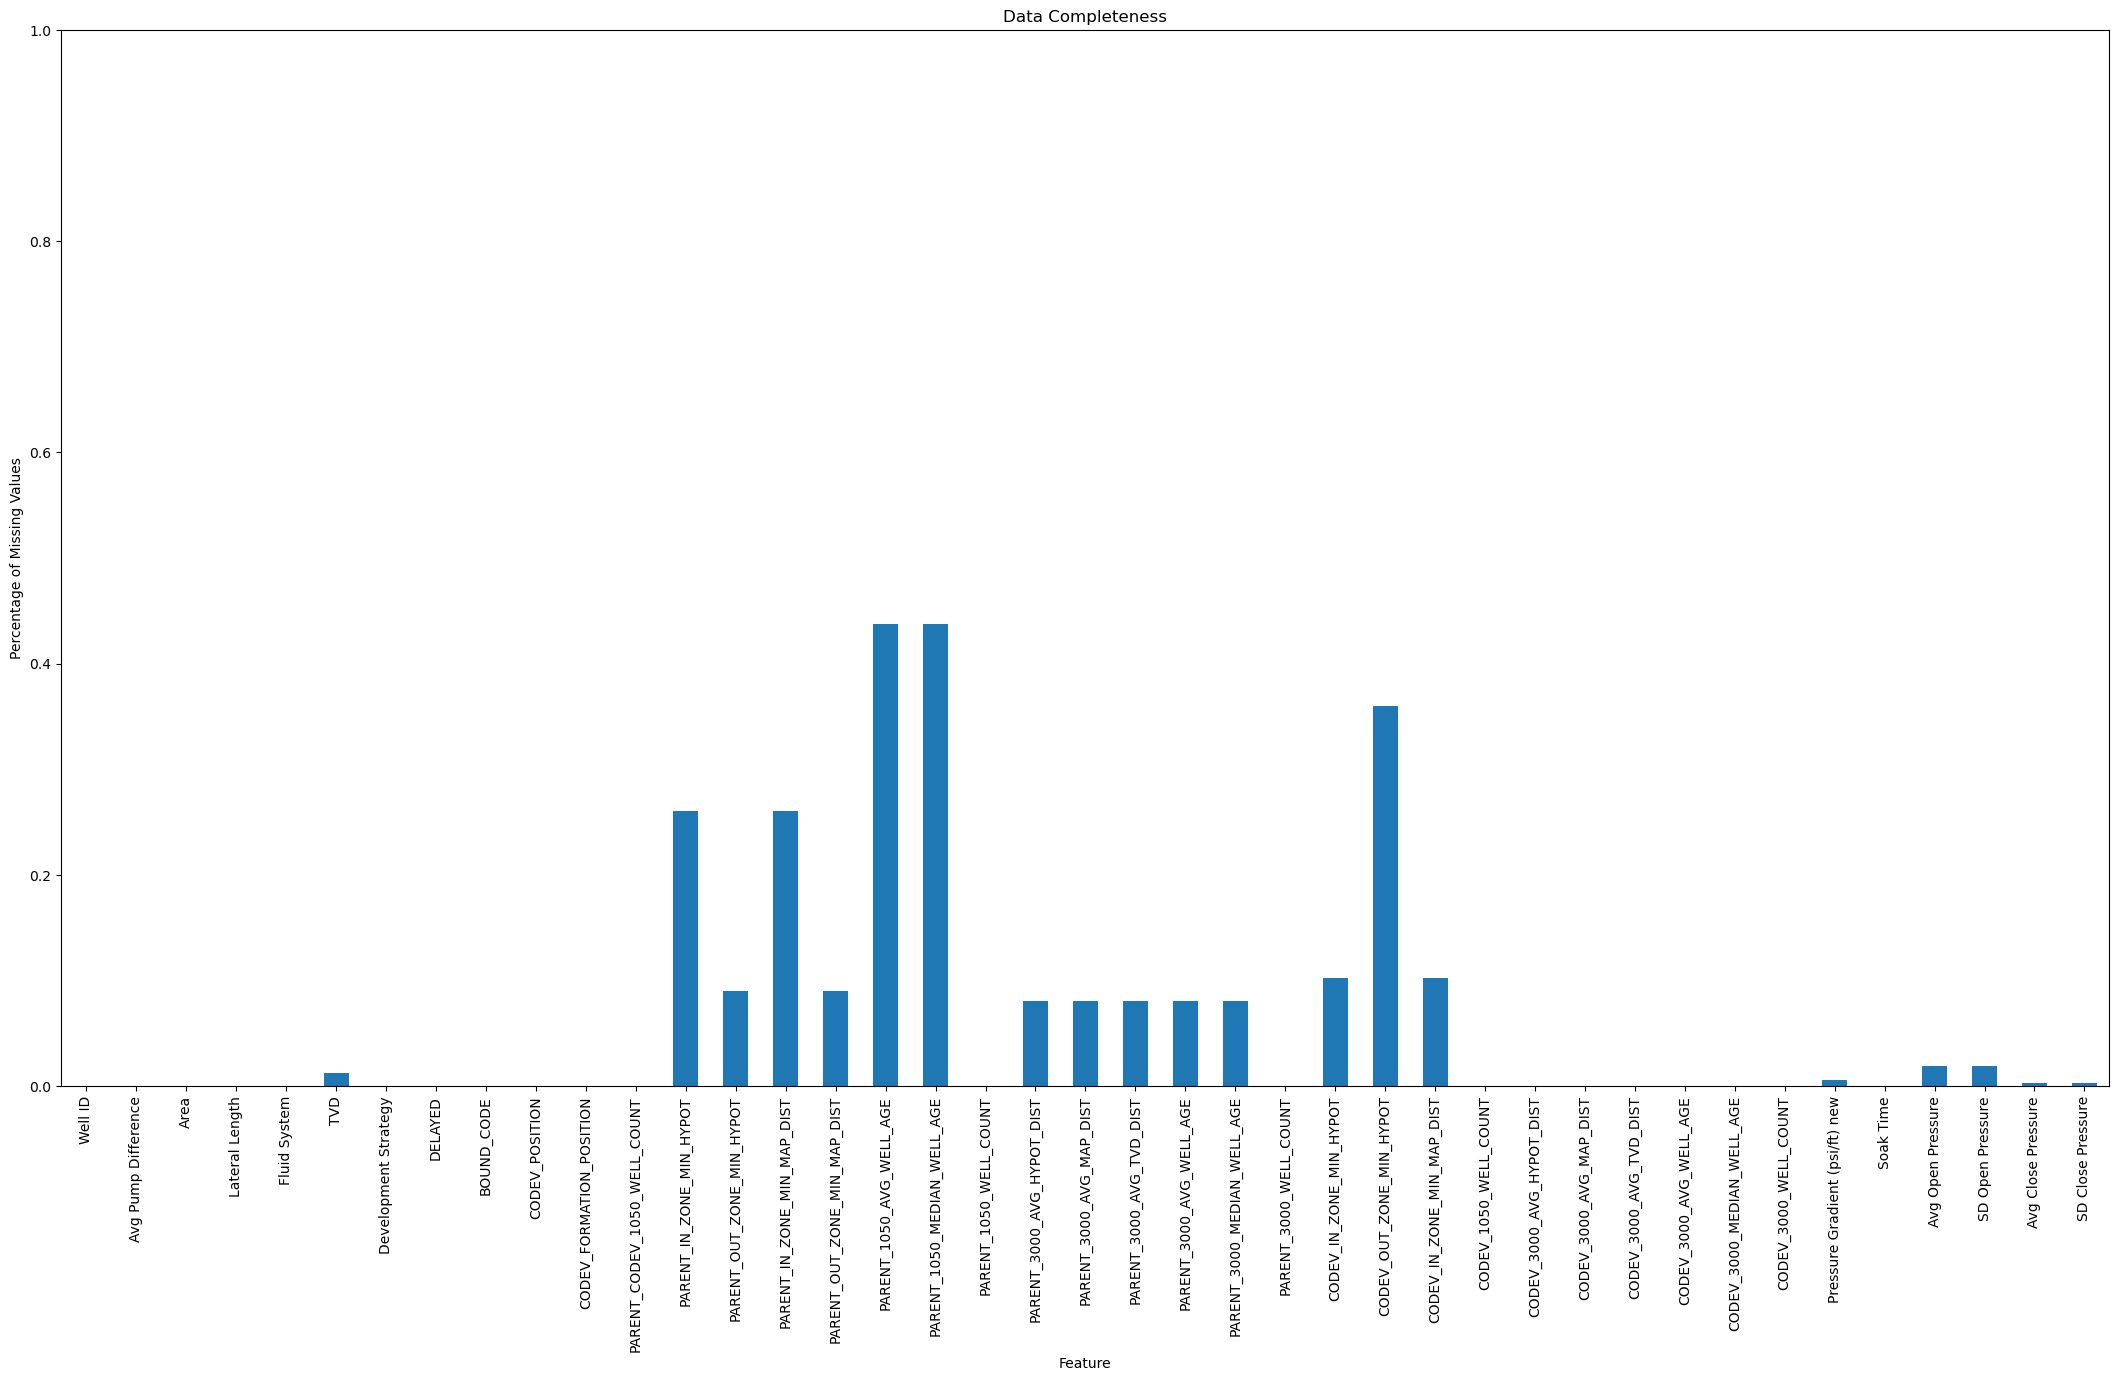

In [9]:
####data completion visualization##################
plt.plot()
(df.isnull().sum()/len(df)).plot(kind = 'bar')          # calculate DataFrame with percentage missing by feature
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Values'); plt.title('Data Completeness'); plt.ylim([0.0,1.0])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

In [10]:
#####first drop the data that is severly missing####
missing_name_list = ["PARENT_IN_ZONE_MIN_MAP_DIST","PARENT_IN_ZONE_MIN_HYPOT","PARENT_1050_AVG_WELL_AGE",\
                     "PARENT_1050_MEDIAN_WELL_AGE","CODEV_OUT_ZONE_MIN_HYPOT"]
df = df.drop(columns=missing_name_list)

In [11]:
df_pred

,Well ID,Avg Pump Difference,Area,Lateral Length,Fluid System,TVD,Development Strategy,DELAYED,BOUND_CODE,CODEV_POSITION,...,CODEV_3000_AVG_TVD_DIST,CODEV_3000_AVG_WELL_AGE,CODEV_3000_MEDIAN_WELL_AGE,CODEV_3000_WELL_COUNT,Pressure Gradient (psi/ft) new,Soak Time,Avg Open Pressure,SD Open Pressure,Avg Close Pressure,SD Close Pressure
3,4,NaN,Arches,11000,Campbell,10555.0,Coke,1,11110000,Edge,...,4,0.0,0.0,1,0.501287,30,2653.539415,206.7,1304.162878,551.5
29,31,NaN,Everglades,10900,Williams,8160.0,Coke,1,10001000,Edge,...,44,5.0,5.0,4,0.489195,105,2641.403093,182.2,2330.649788,712.4
40,42,NaN,Grand Canyon,7600,Campbell,9475.0,Orange Crush,0,111000,Edge,...,689,-1.4,-1.5,10,0.577162,124,3188.784956,153.3,2573.689381,522.2
50,52,NaN,Great Sand Dunes,7500,Campbell,8480.0,Orange Crush,1,11110111,Middle,...,393,1.2,1.0,5,0.562310,220,3082.436237,188.3,2862.491012,402.2
69,71,NaN,Great Basin,9800,Young,10545.0,Coke,1,11111000,Edge,...,17,0.0,0.0,1,0.500517,62,NaN,NaN,1554.261093,218.6
74,76,NaN,Kings Canyon,9900,Campbell,8985.0,Orange Crush,1,11111101,Edge,...,626,0.7,1.0,3,0.562929,435,3397.596960,261.9,2263.980877,370.3
89,96,NaN,Carlsbad Caverns,10100,Williams,8335.0,Mountain Dew,0,10001001,Middle,...,21,7.1,16.0,7,0.514748,47,2756.766649,188.4,2073.483878,380.3
124,131,NaN,Big Bend,10200,Williams,8860.0,Mountain Dew,1,11111010,Middle,...,195,0.0,0.0,5,0.588177,491,3120.067826,214.9,2437.221124,529.3
130,137,NaN,Dry Tortugas,7300,Campbell,8920.0,Orange Crush,1,11011000,Edge,...,400,2.0,2.0,2,0.606818,38,3148.416568,146.8,3195.083894,1018.0
187,194,NaN,Great Basin,10000,Young,8915.0,Orange Crush,1,11111100,Edge,...,664,12.0,12.0,4,0.523895,100,2471.255945,105.0,2472.226587,313.8


In [12]:
df_pred = df_pred.drop(columns=missing_name_list)

In [13]:
df.shape

(322, 36)

In [14]:
X = df.iloc[:,2:] #####features
X_pred = df_pred.iloc[:,2:]
Y = df.iloc[:,1]  #####response feature

In [15]:
num_fea = list(X.select_dtypes('number'))
cat_fea = list(X.select_dtypes('object'))

In [16]:
#for column in num_fea:
#    column_mean = X[column].mean()
#    X[column].fillna(column_mean,inplace=True)
for column in num_fea:
    column_median = X[column].median()
    X[column].fillna(column_median,inplace=True)
    column_median_pred = X_pred[column].median()
    X_pred[column].fillna(column_median_pred,inplace=True)    

In [17]:
label_encoders = {} 
for column in cat_fea: 
    label_encoders[column] = LabelEncoder() 
    X[column] = label_encoders[column].fit_transform(X[column])
    X_pred[column] = label_encoders[column].fit_transform(X_pred[column]) 

In [18]:
scaler = StandardScaler() 
X[num_fea] = scaler.fit_transform(X[num_fea])
X_pred[num_fea] = scaler.fit_transform(X_pred[num_fea])

In [ ]:
X

In [ ]:
#####do the correlation test
plot_corr(X,size=39)

In [ ]:
vif_values = []
for i in range(X.shape[1]):
    vif_values.append(variance_inflation_factor(X.values, i))

vif_values = np.asarray(vif_values)
indices = np.argsort(vif_values)[::1]                  # find indicies for descending order

plt.plot()                                        # plot the feature importance 
plt.title("Variance Inflation Factor")
plt.bar(range(X.shape[1]), vif_values[indices],edgecolor = 'black',
       color="darkorange",alpha=0.6, align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation=90); 

plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
#plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

plt.xlim([-0.5, X.shape[1]-0.5]); plt.yscale('log'); plt.ylim([1.0e1,1.0e4])
plt.xlabel('Predictor Feature'); plt.ylabel('Variance Inflation Factor')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
random_forest_accuracy(X,Y)

[30 28  2 32 29 31 18  3 17 13 33  1 11  0 23 10 16 14 22 24 15 20 19 27
  6 25  9 26 12 21  4  7  8  5]
Index(['Avg Open Pressure', 'Pressure Gradient (psi/ft) new', 'Fluid System',
       'Avg Close Pressure', 'Soak Time', 'SD Open Pressure',
       'PARENT_3000_WELL_COUNT', 'TVD', 'PARENT_3000_MEDIAN_WELL_AGE',
       'PARENT_3000_AVG_HYPOT_DIST', 'SD Close Pressure', 'Lateral Length',
       'PARENT_OUT_ZONE_MIN_MAP_DIST', 'Area', 'CODEV_3000_AVG_MAP_DIST',
       'PARENT_OUT_ZONE_MIN_HYPOT', 'PARENT_3000_AVG_WELL_AGE',
       'PARENT_3000_AVG_MAP_DIST', 'CODEV_3000_AVG_HYPOT_DIST',
       'CODEV_3000_AVG_TVD_DIST', 'PARENT_3000_AVG_TVD_DIST',
       'CODEV_IN_ZONE_MIN_MAP_DIST', 'CODEV_IN_ZONE_MIN_HYPOT',
       'CODEV_3000_WELL_COUNT', 'BOUND_CODE', 'CODEV_3000_AVG_WELL_AGE',
       'PARENT_CODEV_1050_WELL_COUNT', 'CODEV_3000_MEDIAN_WELL_AGE',
       'PARENT_1050_WELL_COUNT', 'CODEV_1050_WELL_COUNT',
       'Development Strategy', 'CODEV_POSITION', 'CODEV_FORMATION_POSITION',
   

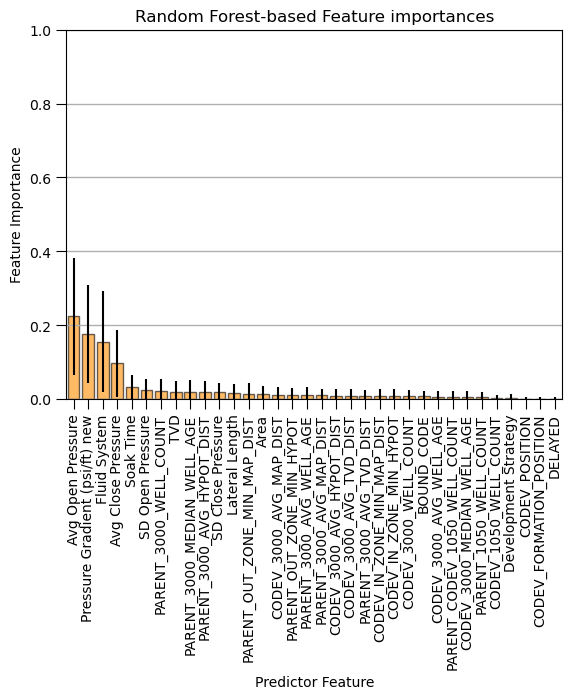

In [19]:
indices, selected_feature_list = random_forest_feature_selection(X,Y)

Feature ranking:
1. feature Pressure Gradient (psi/ft) new = 1.000000
2. feature Avg Open Pressure = 0.853991
3. feature Fluid System = 0.633248
4. feature Avg Close Pressure = 0.499207
5. feature Soak Time = 0.469775
6. feature TVD = 0.386586
7. feature PARENT_OUT_ZONE_MIN_HYPOT = 0.341346
8. feature PARENT_OUT_ZONE_MIN_MAP_DIST = 0.264207
9. feature Area = 0.263528
10. feature CODEV_IN_ZONE_MIN_HYPOT = 0.229521
11. feature CODEV_IN_ZONE_MIN_MAP_DIST = 0.221498
12. feature PARENT_3000_WELL_COUNT = 0.213272
13. feature PARENT_3000_AVG_HYPOT_DIST = 0.146925
14. feature SD Close Pressure = 0.141714
15. feature CODEV_3000_AVG_WELL_AGE = 0.134718
16. feature PARENT_3000_MEDIAN_WELL_AGE = 0.092803
17. feature CODEV_3000_WELL_COUNT = 0.074437
18. feature SD Open Pressure = 0.058524
19. feature CODEV_3000_AVG_HYPOT_DIST = 0.026469
20. feature PARENT_3000_AVG_MAP_DIST = 0.024079
21. feature PARENT_3000_AVG_WELL_AGE = 0.022470
22. feature Lateral Length = 0.005075
23. feature CODEV_POSITION = 0

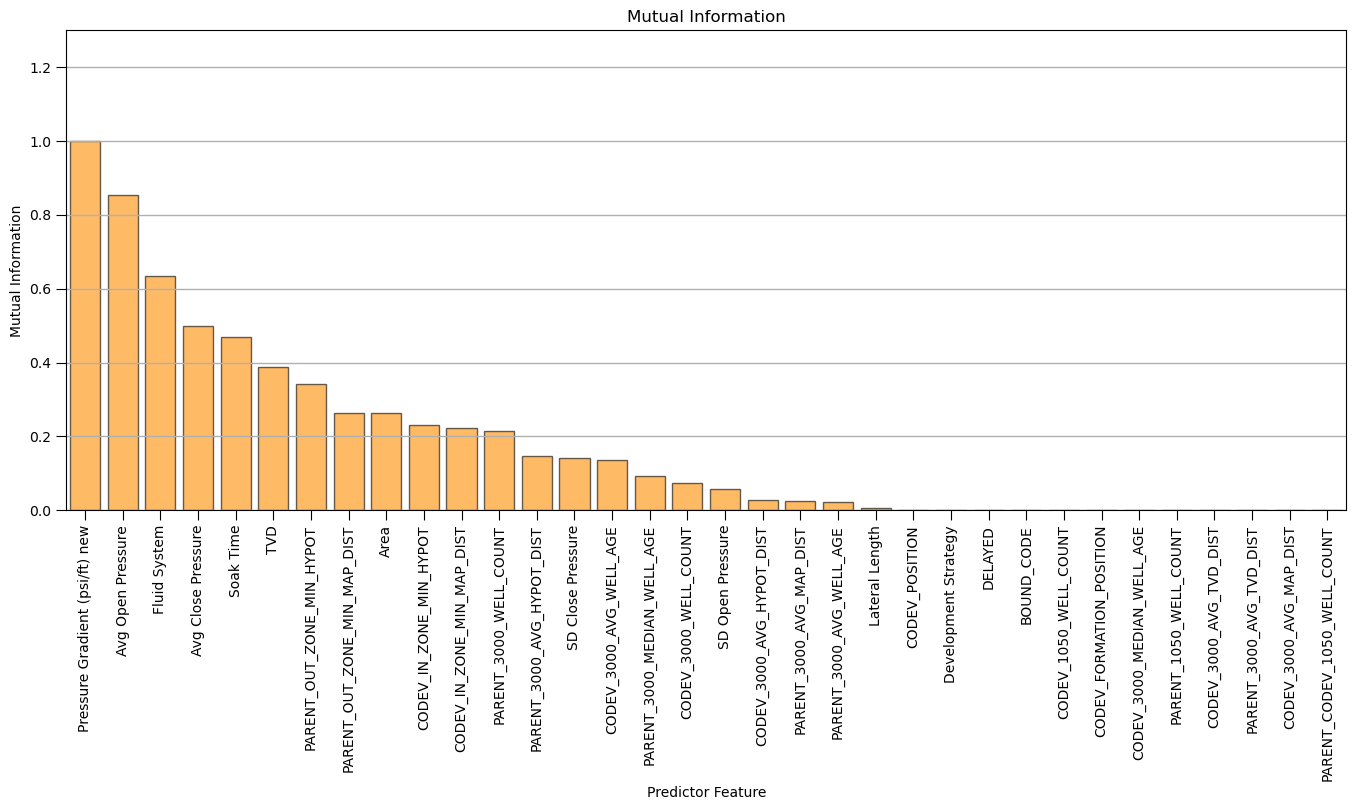

In [20]:
indices_mutual, indices_name_mutual = mutual_info_feature_selection(X,Y)

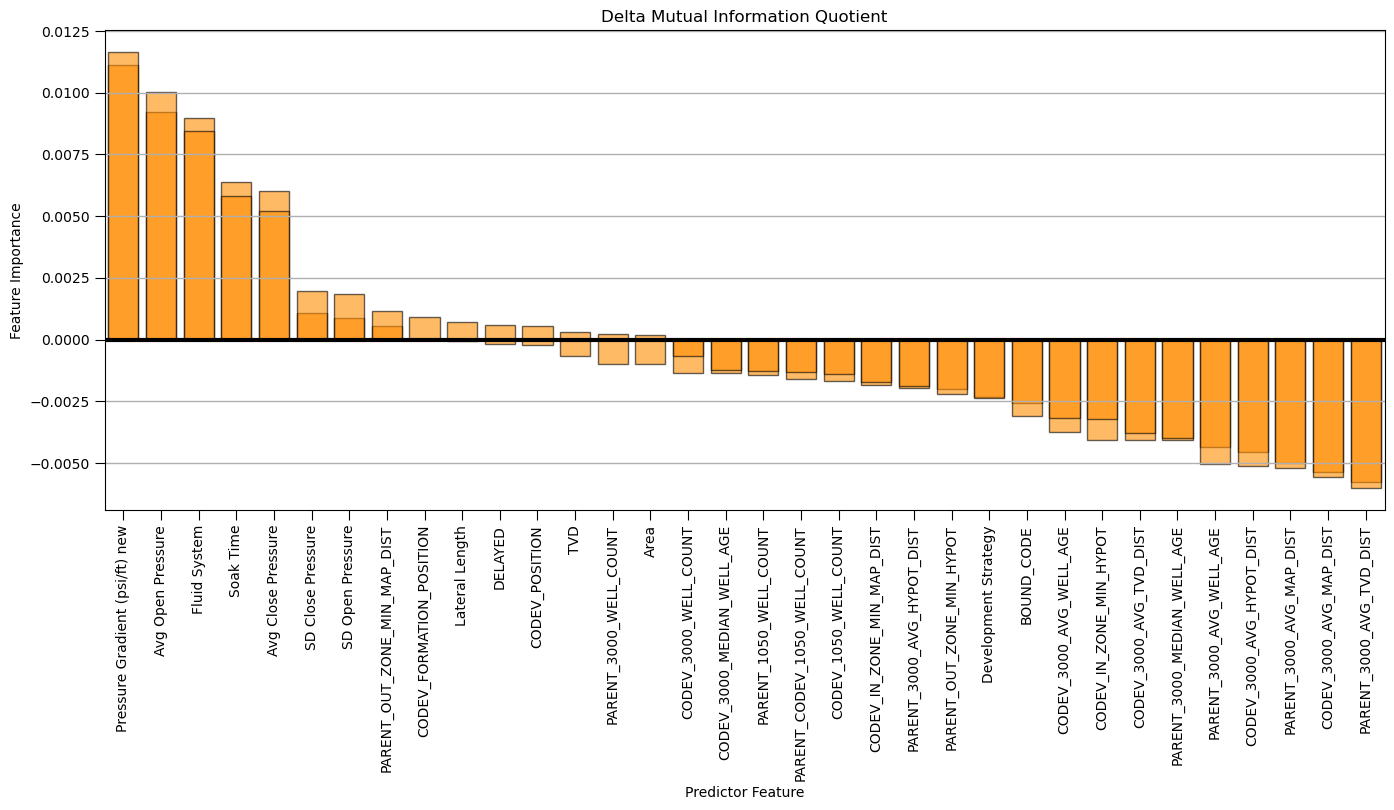

In [37]:
delta_mutual_information = delta_mutual_information_quotient(X,Y)

#delta_mutual_information = (delta_mutual_information - np.min(delta_mutual_information))/(np.max(delta_mutual_information) - np.min(obj_mutual))
indices_delta_mutual_information = np.argsort(delta_mutual_information)[::-1]            # find indicies for descending order

plt.subplot(111)                          # plot the relative mutual information 
plt.title("Delta Mutual Information Quotient")
plt.bar(range(X.shape[1]), delta_mutual_information[indices_delta_mutual_information],
       color="darkorange",alpha = 0.6,align="center",edgecolor = 'black')
plt.xticks(range(X.shape[1]), X.columns[indices_delta_mutual_information],rotation=90)
plt.xlim([-0.5, X.shape[1]-0.5])
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
#plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.plot([-0.5,X.shape[1]-0.5],[0,0],color='black',lw=3); plt.xlabel('Predictor Feature'); plt.ylabel('Feature Importance')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.5)
plt.show()

In [22]:
#new_indice = np.append(indices_mutual[:12])
#print(new_indice)
X_selected = X.iloc[:,indices_mutual[:12]]
X_pred = X_pred.iloc[:,indices_mutual[:12]]

In [23]:
X_selected.shape
X_selected.shape

(322, 12)

In [ ]:
random_forest_accuracy(X_selected,Y)

Mean squared error for testing: 146.50
Coefficient of determination for testing: 0.76
Coefficient of determination for training: 0.88


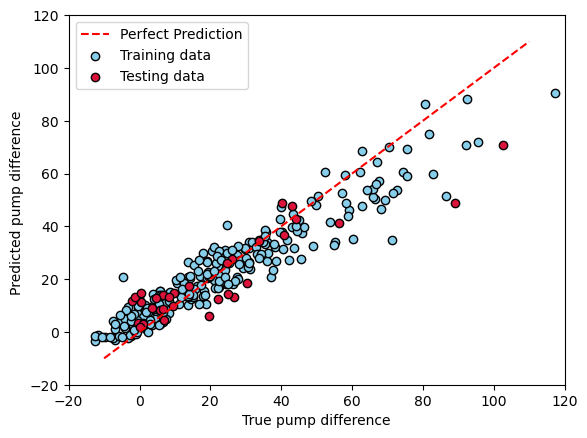

In [35]:
seed = 42                                # set the random forest hyperparameters
max_depth = 10
min_samples_leaf = 2
num_tree = 200
max_features = 4
random_forest = RandomForestRegressor(min_samples_leaf = min_samples_leaf,random_state=seed,n_estimators=num_tree, max_features=max_features)

#####split the data#####
X_train, X_test, Y_train, Y_test = train_test_split(X_selected,Y,random_state=seed,test_size=0.1, shuffle=True)

random_forest.fit(X_train,Y_train) # fit the random forest

Y_pred = random_forest.predict(X_test)
Y_train_pred = random_forest.predict(X_train)

# The mean squared error
print("Mean squared error for testing: %.2f" % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination for testing: %.2f" % r2_score(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination for training: %.2f" % r2_score(Y_train, Y_train_pred))

    
#plt.figure(figsize=(6,6))
plt.scatter(Y_train,Y_train_pred,color='skyblue',edgecolor="black",label='Training data')
plt.scatter(Y_test,Y_pred,color='crimson',edgecolor="black",label='Testing data')
plt.xlabel("True pump difference");plt.ylabel("Predicted pump difference ")
x_= np.linspace(-10,110,100);y_= x_;
plt.plot(x_,y_,color='red', linestyle='--', label= 'Perfect Prediction')
plt.legend(loc='best')
plt.xlim([-20,120])
plt.ylim([-20,120])
#plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1, wspace=0.2, hspace=0.3);
plt.show()

In [33]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y, test_size=0.25, random_state=42) 
# Create an instance of the model
random_forest = RandomForestRegressor(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [2, 10, 20], 
    'min_samples_leaf': [2, 4, 8], 
    'max_features': [4,7,3]
} 

# Create GridSearchCV with cross-validation
grid_search = GridSearchCV(
    random_forest, 
    param_grid, 
    cv=5,  # Number of cross-validation folds
    scoring='neg_mean_squared_error',  # Scoring metric
    n_jobs=-1
)

# Fit the grid search to find the best hyperparameters
grid_search.fit(X_train, Y_train)

# Display the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model using cross-validation
cv_scores = cross_val_score(best_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores  # Convert negative MSE to positive

# Display the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", np.mean(cv_scores))

Best Hyperparameters: {'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 2, 'n_estimators': 50}
Cross-Validation Scores: [321.09734168 215.94296625 288.93803852 281.16994011 337.36636149]
Mean Cross-Validation Score: 288.9029296098596


# Uncertainty Analysis of Random Forest Model

In [ ]:
bs_num = 100
bootstrap_predictions = np.zeros((len(X_pred), bs_num)) 
for i in range(bs_num):
    ####pick the training data
    L = X_selected.shape[0]
    bs_indices = np.random.choice(L, L, replace=True) 
    bs_X = X_selected.iloc[bs_indices]
    bs_Y = Y.iloc[bs_indices]
    ####traain the model
    random_forest = RandomForestRegressor(n_estimators=100, max_depth = 10, min_samples_leaf = 2, \
                                      max_features = 3, random_state=42)
    random_forest.fit(bs_X, bs_Y)
    bootstrap_predictions[:, i] = random_forest.predict(X_pred)

In [ ]:
bootstrap_predictions.shape

In [ ]:
np.savetxt('./solution.csv',bootstrap_predictions, delimiter = ',')

In [ ]:
print(bootstrap_predictions)

In [ ]:
# Create a Random Forest model 
random_forest = RandomForestRegressor(n_estimators=100, max_depth = 10, min_samples_leaf = 2, \
                                      max_features = 3, random_state=42) 


# Train the model 
random_forest.fit(X_selected, Y)
# Generate predictions on the test set 
Y_final_pred = random_forest.predict(X_pred) 
# Calculate bootstrapped confidence intervals 
n_bootstraps = 100 
bootstrap_predictions = np.zeros((len(X_pred), n_bootstraps)) 
for i in range(n_bootstraps): 
    # Create a bootstrap sample 
    indices = np.random.choice(len(X_pred), len(X_pred), replace=True) 
    bootstrap_sample = X_test.iloc[indices] 
    # Make predictions on the bootstrap sample 
    bootstrap_predictions[:, i] = random_forest.predict(bootstrap_sample) 
    # Calculate confidence intervals 
    lower_bound = np.percentile(bootstrap_predictions, 2.5, axis=1) 
    upper_bound = np.percentile(bootstrap_predictions, 97.5, axis=1) 
    # Print or visualize the confidence intervals
    

In [ ]:
bootstrap_predictions.shape

In [ ]:
# Assuming you have calculated lower_bound and upper_bound 
# Create a range of indices for the x-axis 
x_indices = np.arange(len(X_test)) 
# Plot the predictions 
plt.plot(x_indices, bootstrap_predictions, label='Predictions', color='blue') 
# Plot the confidence intervals as shaded regions 
#plt.fill_between(x_indices, lower_bound, upper_bound, color='lightgray', label='95% Confidence Intervals') 
# Add labels and title 
plt.xlabel('Sample Index') 
plt.ylabel('Predicted Value') 
plt.title('Predictions with Confidence Intervals') 
# Show legend 
#plt.legend()

plt.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_selected,Y, random_state=seed,test_size=0.20, shuffle=True)

DT = DecisionTreeRegressor(max_depth=12)
DT.fit(X_train, Y_train)

# Predict
Y_pred = DT.predict(X_test)
Y_train_pred = DT.predict(X_train)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))

plt.scatter(Y_test,Y_pred,label = "Test")
plt.scatter(Y_train,Y_train_pred,label = "Train")
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.show()

In [ ]:
seed = 7275647
X_train, X_test, Y_train, Y_test = train_test_split(X_selected,Y, random_state=seed,test_size=0.20, shuffle=True)
reg = LinearRegression().fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
Y_train_pred = reg.predict(X_train)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))

plt.scatter(Y_test,Y_pred,label = "Test")
plt.scatter(Y_train,Y_train_pred,label = "Train")
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.show()

In [ ]:
seed =654646
X_train, X_test, Y_train, Y_test = train_test_split(X_selected,Y, random_state=seed,test_size=0.20, shuffle=True)

model = MLPRegressor(hidden_layer_sizes=(15),learning_rate_init=0.01,alpha=0.5,random_state=0).fit(X_train,Y_train)

Y_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))

plt.scatter(Y_test,Y_pred,label = "Test")
plt.scatter(Y_train,Y_train_pred,label = "Train")
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.show()